In [971]:
'''=============================================================
===================== SECTION IMPORTS ==========================
================================================================'''
from time import time

# General imports
import pandas as pd
from pandas.tseries.offsets import DateOffset
import numpy as np
import sklearn.base
from numpy import logspace, linspace
from pandas import DataFrame
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso, ElasticNetCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split, cross_validate, RandomizedSearchCV
from tqdm import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [972]:
# Defines the path to the dataset folder
your_datapath = '../data/ZHL/'
#district_name = "Afgooye" #Adan Yabaal, Afgooye, Afmadow

# new features data path
acled_datapath = '../data/acled/'


# new features data path
acled_result_savepath = '../data/acled/results/'

## Function Definations

In [973]:
# Function that creates a pandas dataframe for a single district with columns for the baseline model with semi-yearly entries
def make_district_df_semiyearly(datapath, acled_datapath, district_name):

    """
    Function that creates a pandas dataframe for a single district with columns for the baseline model with semiyearly entries

    Parameters
    ----------
    datapath : string
        Path to the datafolder
    district_name : string
        Name of the district

    Returns
    -------
    df : pandas dataframe
    """

    # Read all relevant datasets
    prevalence_df = pd.read_csv(datapath + 'prevalence_v3.csv', parse_dates=['date'])
    covid_df = pd.read_csv(datapath + 'covid.csv', parse_dates=['date'])
    ipc_df = pd.read_csv(datapath + 'ipc2.csv', parse_dates=['date'])
    risk_df = pd.read_csv(datapath + 'FSNAU_riskfactors.csv', parse_dates=['date'])
    production_df = pd.read_csv(datapath + 'production.csv', parse_dates=['date'])


    # Select data for specific district
    prevalence_df = prevalence_df[prevalence_df['district'] == district_name]
    ipc_df = ipc_df[ipc_df['district'] == district_name]
    risk_df = risk_df[risk_df['district'] == district_name]
    production_df = production_df[production_df['district'] == district_name]

    
    # risk factor df, as we proposed, use MS(month start) rather then M(month end)
    # the important thing here is we do not have the data before 2017-01-01, so ideally 2017-01-01 nvidi score should be null for all columns
    risk_df = risk_df.groupby(pd.Grouper(key='date', freq='6MS')).mean()
    risk_df = risk_df.shift(periods = 6, freq='M')


    # covid df, as we proposed, use MS(month start) rather then M(month end)
    covid_df = covid_df.groupby(pd.Grouper(key='date', freq='6MS')).sum()
    risk_df = risk_df.shift(periods = 6, freq='M')


    # crop production df
    production_df['cropdiv'] = production_df.count(axis=1)


    # Sort dataframes on date
    prevalence_df.sort_values('date', inplace=True)
    covid_df.sort_values('date', inplace=True)
    ipc_df.sort_values('date', inplace=True)
    risk_df.sort_values('date', inplace=True)
    production_df.sort_values('date', inplace=True)


    # Merge dataframes, only joining on current or previous dates as to prevent data leakage
    df = pd.merge_asof(left=prevalence_df, right=ipc_df, direction='backward', on='date')
    df = pd.merge_asof(left=df, right=production_df, direction='backward', on='date')
    df = pd.merge_asof(left=df, right=risk_df, direction='backward', on='date')
    df = pd.merge_asof(left=df, right=covid_df, direction='backward', on='date')


    # Calculate prevalence 6lag, we have already adjusted next_prevalence in new prevelence data
    df['prevalence_6lag'] = df['GAM Prevalence'].shift(1)
    # df['next_prevalence'] = df['GAM Prevalence'].shift(-1)


    # Select needed columns
    df = df[['date', 'district', 'GAM Prevalence', 'next_prevalence', 'prevalence_6lag', 'new_cases', 'ndvi_score',
             'phase3plus_perc', 'cropdiv', 'total population']]
    df.columns = ['date', 'district', 'prevalence', 'next_prevalence', 'prevalence_6lag', 'covid', 'ndvi', 'ipc',
                  'cropdiv', 'population']

    # Add month column
    df['month'] = df['date'].dt.month

    # Add target variable: increase for next month prevalence (boolean)
    increase = [False if x[1] < x[0] else True for x in list(zip(df['prevalence'], df['prevalence'][1:]))]
    increase.append(False)
    df['increase'] = increase
    df.iloc[-1, df.columns.get_loc('increase')] = np.nan  # No info on next month

    # Add target variable: increase for next month prevalence (boolean)
    increase_numeric = [x[1] - x[0] for x in list(zip(df['prevalence'], df['prevalence'][1:]))]
    increase_numeric.append(0)
    df['increase_numeric'] = increase_numeric
    df.iloc[-1, df.columns.get_loc('increase_numeric')] = np.nan  # No info on next month

    # filling covid patients as 0 before covid started
    df.loc[np.isnan(df["covid"]), 'covid'] = 0

    return (df)

In [974]:
# Function to combine conflict features to the base dataframe
def combine_conflict_features(df,district_name):
    
    # read conflict datasets/features 6m, 1y and 1.5y
    conflict_6Mdf = pd.read_csv(acled_datapath + 'features_6m.csv', parse_dates=['date'])
    conflict_1ydf = pd.read_csv(acled_datapath + 'features_1y.csv', parse_dates=['date'])
    conflict_1y6mdf = pd.read_csv(acled_datapath + 'features_1y6m.csv', parse_dates=['date'])
    
    # extract district from 6m, 1y and 1.5y, rename, and drop repeated information which is already present in base dataframe 

    # 6m
    conflict_df_district_6m = conflict_6Mdf[conflict_6Mdf['district'] == district_name].copy()
    conflict_df_district_6m.drop(columns=['next_prevalence','district','GAM Prevalence','district_encoded'],inplace=True)
    renamed_columns = ['date'] + [col+'_6m' for col in conflict_df_district_6m.columns[1:]]
    conflict_df_district_6m.columns = renamed_columns
    conflict_df_district_6m.sort_values('date', inplace=True)

    # 1y
    conflict_df_district_1y = conflict_1ydf[conflict_1ydf['district'] == district_name].copy()
    conflict_df_district_1y.drop(columns=['next_prevalence','district','GAM Prevalence','district_encoded'],inplace=True)
    renamed_columns = ['date'] + [col+'_1y' for col in conflict_df_district_1y.columns[1:]]
    conflict_df_district_1y.columns = renamed_columns
    conflict_df_district_1y.sort_values('date', inplace=True)

    #1y6m
    conflict_df_district_1y6mdf = conflict_1y6mdf[conflict_1y6mdf['district'] == district_name].copy()
    conflict_df_district_1y6mdf.drop(columns=['next_prevalence','district','GAM Prevalence','district_encoded'],inplace=True)
    renamed_columns = ['date'] + [col+'_1y6m' for col in conflict_df_district_1y6mdf.columns[1:]]
    conflict_df_district_1y6mdf.columns = renamed_columns
    conflict_df_district_1y6mdf.sort_values('date', inplace=True)


    # merge dataframe with the base dataframe
    df = pd.merge_asof(left=df, right=conflict_df_district_6m, direction='backward', on='date')
    df = pd.merge_asof(left=df, right=conflict_df_district_1y, direction='backward', on='date')
    df = pd.merge_asof(left=df, right=conflict_df_district_1y6mdf, direction='backward', on='date')

    return df
    


In [975]:
# Function that combines the semiyearly dataset (from the function make_district_df_semiyearly) of all districts
def make_combined_df_semiyearly(datapath,acled_datapath,implementation):
    """
    Function that creates a pandas dataframe for all districts with columns for the baseline model with semiyearly entries

    Parameters
    ----------
    datapath : string
        Path to the datafolder

    Returns
    -------
    df : pandas dataframe
    """

    prevdf = pd.read_csv(datapath + 'prevalence_estimates.csv', parse_dates=['date'])
    districts = prevdf['district'].unique()

    df_list = []
    for district in districts:
        district_df = make_district_df_semiyearly(datapath, acled_datapath, district)
        if implementation=='new':
            district_df = combine_conflict_features(district_df,district)
        district_df['district'] = district
        df_list.append(district_df)

    df = pd.concat(df_list, ignore_index=True)
    df['district_encoded'] = df['district'].astype('category').cat.codes

    return df

## =================================================================================================
## MAIN FUNCTION

In [997]:
# select between "new" and "old" implementation to reproduce results
implementation = 'new'

In [998]:
# Create the dataframe for all districts
df = make_combined_df_semiyearly(your_datapath,acled_datapath,implementation)
df

,date,district,prevalence,next_prevalence,prevalence_6lag,covid,ndvi,ipc,cropdiv,population,...,actor1_Police Forces of Somaliland (2010-)_1y,actor2_Police Forces of Somaliland (2010-)_1y6m,interaction_12_1y6m,fatalities_1y6m,interaction_27_1y6m,actor2_Al Shabaab_1y6m,actor1_Police Forces of Somalia (2017-2022)_1y6m,actor1_Military Forces of Somalia (2017-2022)_1y6m,actor2_Military Forces of Somalia (2017-2022)_1y6m,district_encoded
0,2017-07-01,Adan Yabaal,0.369200,0.351000,NaN,0.0,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1,2018-01-01,Adan Yabaal,0.351000,0.278939,0.369200,0.0,0.231667,NaN,4.0,51766.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,2018-07-01,Adan Yabaal,0.278939,0.395974,0.351000,0.0,0.215000,NaN,4.0,129760.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,2019-01-01,Adan Yabaal,0.395974,0.340623,0.278939,0.0,0.253333,NaN,4.0,66069.733424,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
4,2019-07-01,Adan Yabaal,0.340623,0.312611,0.395974,0.0,0.270000,NaN,3.0,197917.204949,...,0.0,0.0,0.0,15.0,3.0,1.0,0.0,1.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672,2017-07-01,Ceel barde,0.486200,0.486200,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41
673,2018-01-01,Ceel barde,0.486200,NaN,0.486200,0.0,NaN,NaN,NaN,113789.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41
674,2017-07-01,Mogadishu,0.389306,0.291200,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68
675,2018-01-01,Mogadishu,0.291200,NaN,0.389306,0.0,NaN,NaN,NaN,515337.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68


In [999]:
print("Total no of district before droping are - ",len(df['district'].value_counts().keys()))

Total no of district before droping are -  87


In [1000]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
prevalence,677.0,0.376678,0.097403,0.091189,0.312611,0.384560,0.445262,6.739054e-01
next_prevalence,580.0,0.369922,0.099899,0.091189,0.301736,0.378832,0.441803,6.739054e-01
prevalence_6lag,590.0,0.378064,0.098194,0.091189,0.315132,0.384463,0.446185,6.480009e-01
covid,677.0,1909.134417,3265.520513,0.000000,0.000000,0.000000,3310.000000,1.020900e+04
ndvi,562.0,0.265261,0.118866,0.000000,0.171667,0.239167,0.346250,6.233333e-01
ipc,600.0,0.132433,0.106511,0.000000,0.060000,0.110000,0.170000,5.800000e-01
cropdiv,350.0,5.180000,1.905850,2.000000,4.000000,5.000000,6.000000,1.000000e+01
population,603.0,167638.360262,253802.381375,14000.000000,64346.000000,99157.000000,180166.419425,2.228463e+06
month,677.0,4.341211,2.982736,1.000000,1.000000,7.000000,7.000000,7.000000e+00
increase_numeric,590.0,-0.007229,0.085416,-0.272960,-0.060893,-0.010947,0.041342,3.292577e-01


- here we have 677 data points
- since the cropdiv has only 350 data points, so if we use directly use dropna (dropping values with NaN), the data points will be below 350 of course because we have NaN values for those crop diversity so we will drop the crop diversity and use the dropna for the rest

In [1001]:
# Drop every row with missing values
# drop cropdiv column as 50% of the data is missing and then apply dropna
df.drop(columns=['cropdiv'],inplace=True)

In [1002]:
# drop the rows with NaN values 
df.dropna(inplace=True)

In [1003]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
prevalence,444.0,0.369783,0.100725,0.091189,0.306113,0.378801,0.444570,6.480009e-01
next_prevalence,444.0,0.371572,0.101535,0.091189,0.301998,0.379535,0.447385,6.480009e-01
prevalence_6lag,444.0,0.380481,0.095590,0.091189,0.330956,0.391757,0.444600,6.480009e-01
covid,444.0,1062.398649,1661.970281,0.000000,0.000000,0.000000,3310.000000,3.947000e+03
ndvi,444.0,0.259989,0.115422,0.000000,0.171250,0.235000,0.336667,6.000000e-01
ipc,444.0,0.109977,0.090789,0.000000,0.050000,0.090000,0.150000,5.700000e-01
population,444.0,157097.932199,215388.572648,14000.000000,62721.145713,99157.000000,178810.116688,2.228463e+06
month,444.0,3.581081,2.973958,1.000000,1.000000,1.000000,7.000000,7.000000e+00
increase_numeric,444.0,0.001789,0.080851,-0.272960,-0.047088,0.001752,0.051598,2.640650e-01
actor1_Al Shabaab_6m,444.0,5.085586,12.447519,0.000000,0.000000,1.000000,5.000000,1.300000e+02


In [1004]:
# Sort dataframe on date and reset the index
df.sort_values('date', inplace=True)
df.reset_index(inplace=True, drop=True)

In [1005]:
# checking district counts and printing district values with less then threshold_count (minimum number of observations required to feed per district)
# threshold_count = 7
# district_counts = df['district'].value_counts()
# district_counts[district_counts.values < threshold_count]

In [1006]:
# Drop districts with less than 7 observations for conflict data, similar approach as baseline model
# these should be drooped from both new and old implementations to keep the data and comparision same
# to get these districts uncomment the above code
district_with_less_data = ['Baki', 'Bandarbeyla', 'Burco', 'Xudun', 'Ceel Barde', 'Jariiban', 'Cadaado', 'Cabudwaaq', 'Saakow', 'Laasqoray', 'Lughaye', 'Rab Dhuure', 'Baydhaba']
df.drop(df[df['district'].isin(district_with_less_data)].index, inplace=True)

In [1007]:
district_count = len(df['district'].value_counts().keys())
print("Total no of district after droping are - ",district_count)

Total no of district after droping are -  55


In [1008]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
prevalence,385.0,0.373357,0.099162,0.127787,0.308138,0.384843,0.446990,6.480009e-01
next_prevalence,385.0,0.375064,0.098915,0.127787,0.306085,0.385832,0.450524,6.480009e-01
prevalence_6lag,385.0,0.384777,0.092936,0.127787,0.338780,0.392600,0.446208,6.480009e-01
covid,385.0,1036.714286,1650.150750,0.000000,0.000000,0.000000,3310.000000,3.947000e+03
ndvi,385.0,0.268303,0.118285,0.000000,0.176667,0.243333,0.350000,6.000000e-01
ipc,385.0,0.107039,0.088185,0.000000,0.040000,0.090000,0.140000,5.700000e-01
population,385.0,153242.667653,199954.991381,14000.000000,62826.764284,99157.000000,178810.116688,2.228463e+06
month,385.0,3.571429,2.973094,1.000000,1.000000,1.000000,7.000000,7.000000e+00
increase_numeric,385.0,0.001707,0.082335,-0.272960,-0.046003,0.000964,0.052243,2.640650e-01
actor1_Al Shabaab_6m,385.0,5.722078,13.134844,0.000000,0.000000,1.000000,6.000000,1.300000e+02


- So after dropping we are left with 385 data points almost 1.5 times from the baseline model representing **55** districts
- So basically we have 55 districts each with 7 observations

### ===========================================================================================
### RANDOM FOREST 


In [1009]:
'''------------SECTION RANDOM FOREST CROSS VALIDATION--------------'''
#WARNING: this process can take some time, since there are a lot of hyperparameters to investigate. The search space can be manually reduced to speed up the process.

#Create empty list to store model scores
parameter_scores = []

#Define target and explanatory variables
X = df.drop(columns = ['increase', 'increase_numeric', 'date', 'district', 'prevalence', 'next_prevalence']) #Note that these columns are dropped, the remaining columns are used as explanatory variables
y = df['next_prevalence'].values

- so we are keeping 5 data points for each districts for training similar to baseline model, and the remaining 2 data points for each district for predictions
- Number of traing data rows are = Number of districts * 5 observations = 55*5= 275
- Number of testing data rows are = Number of districts * 2 observations = 55* 2 = 110
- Total observations = 275 + 110 = 385

In [1010]:
# divide data in train and test as discussed above
total_observations_per_distrct = 7
training_observations = 5
test_observations = 2

# data to train
train_data_count = district_count*training_observations
test_data_count = district_count*test_observations
print(f"number of observations for training are {train_data_count} and for testing are {test_data_count}")


# divide data
Xtrain = X[:train_data_count]
ytrain = y[:train_data_count]
Xtest = X[train_data_count:]
ytest = y[train_data_count:]

number of observations for training are 275 and for testing are 110


In [1011]:
# The chages made in the baseline model
# 1. removing the loop and training model on the default parameters of random forest 
# 2. since randomeforest itself selects the best parameters(features) we are not performing feature selection although 
# this approach can be extended by selecting best hyperparameters for random forest model using paramter tunning

#Create a RandomForestRegressor with the random state 0.
reg = RandomForestRegressor(random_state=0)

#Fit to the training data
reg.fit(Xtrain, ytrain)

# predicting on training data
predictions = reg.predict(Xtrain)


#Calculate MAE for training data
MAE = mean_absolute_error(ytrain, predictions)


#Generate boolean values for increase or decrease in prevalence. 0 if next prevalence is smaller than current prevalence, 1 otherwise.
# increase           = [0 if x<y else 1 for x,y in zip(df.iloc[:train_data_count]['next_prevalence'],df.iloc[:train_data_count]['prevalence'])]
# predicted_increase = [0 if x<y else 1 for x,y in zip(predictions,df.iloc[:train_data_count]['prevalence'])]


#Calculate accuracy of predicted boolean increase/decrease
# acc = accuracy_score(increase, predicted_increase)

#Training data MAE and accuracy
print('The training MAE for the model is - ')
print(MAE)

The training MAE for the model is - 
0.021117145120009326


<AxesSubplot:>

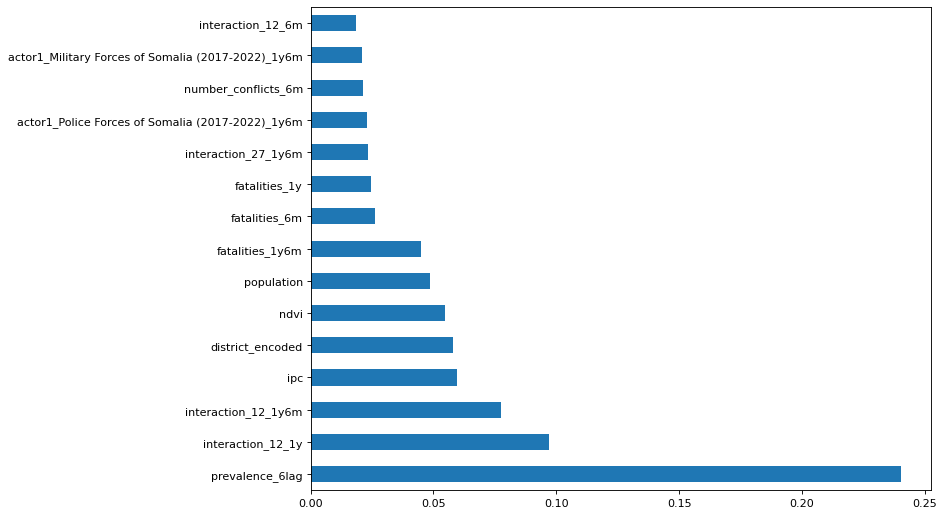

In [1012]:
# calculate feature importance
feat_importances = pd.Series(reg.feature_importances_, index= Xtrain.columns)
feat_importances_df = pd.DataFrame({'features':feat_importances.index, 'entropy_score':feat_importances.values}).sort_values(by=['entropy_score'],ascending=False)
# save important features
filename = acled_result_savepath+implementation+'_model_featureimportance.csv'
feat_importances_df.to_csv(filename,index=False)

# to plot the feature importance
plt.figure(num=None, figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')
feat_importances.nlargest(15).plot(kind='barh')

### MODEL EVALUATION

**NOTE**
    - The code for calculating the classification accuracy in the baseline model was inccorect as well. 
    
**Baseline code**

increase  = [0 if x<y else 1 for x in df.iloc[165:]['next_prevalence'] for y in df.iloc[165:]['prevalence']] \
predicted_increase = [0 if x<y else 1 for x in predictions                      for y in df.iloc[165:]['prevalence']]

- The above code is nested loop that is generating 66*66 = 4356 observations rather then 66. Which means in baseline model's classification accuracy we are comparing each distrcit's increase/decrease with all the other districts (reamining 65).

**Updated code**

increase           = [0 if x<y else 1 for x,y in zip(df.iloc[:train_data_count]['next_prevalence'],df.iloc[:train_data_count]['prevalence'])] \
predicted_increase = [0 if x<y else 1 for x,y in zip(predictions,df.iloc[:train_data_count]['prevalence'])]

- It can be simply fixed by zipping both lists (prediction and original) together.
- Although we dropped "classification accuracy" as an evaluation method.

## Updated Evaluation method (MAE ONLY)

### Baseline Evaluation Method ( MAE and Classification Accuracy )

- Since it is a regression problem, classifing them as increased or decreased can give wrong estimation regarding the model. Here we are trying to predict the prevelence of wasted children, if the next prevelence increased by 0.0001 and the model preidcted that the prevelence is decreased by 0.0001 then even though the model is vary accurate and the difference between the original and prediction is 0.0002, it will be classified as wrong prediction, which is not correct measure at all.

- So we will measure our model performance using Mean Absoulte Error (MAE) only.

In [1013]:
# get predictions on 
predictions = reg.predict(Xtest)

In [1014]:
#Calculate MAE
MAE = mean_absolute_error(ytest, predictions)

In [1015]:
#Print model scores
# old model MAE = 0.0512394083425881
# new model MAE = 0.05013554272083966
print(f"The {implementation} model's MAE(Mean Absolute Error) score is - {MAE}")

The new model's MAE(Mean Absolute Error) score is - 0.05013554272083966


#### SAVE RESULTS

In [1016]:
Xtest['district'] = df.iloc[train_data_count:]['district']
Xtest['date'] = df.iloc[train_data_count:]['date']
Xtest['next_prevalence'] = df.iloc[train_data_count:]['next_prevalence']
Xtest['predictions'] = predictions

/var/folders/5_/kbn_rbxx7r58wh4vqxvfhny40000gn/T/ipykernel_18341/3805482225.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/5_/kbn_rbxx7r58wh4vqxvfhny40000gn/T/ipykernel_18341/3805482225.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/5_/kbn_rbxx7r58wh4vqxvfhny40000gn/T/ipykernel_18341/3805482225.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [1017]:
# saving test results
filename = acled_result_savepath + implementation+'_model_testresults.csv'
Xtest.to_csv(filename,index=False)

## Combining old and new results

- If both new and old test results(csv files) exists in the result folder, results can be combined together

In [1040]:
old_model_results = pd.read_csv('../data/acled/results/old_model_testresults.csv')
old_model_results = old_model_results[['district','date','next_prevalence','predictions']]
old_model_results.columns = ['district','date','next_prevalence','predictions_old']
old_model_results.head()

,district,date,next_prevalence,predictions_old
0,Burtinle,2020-07-01,0.378173,0.384006
1,Garoowe,2020-07-01,0.312887,0.307260
2,Qardho,2020-07-01,0.353924,0.379710
3,Doolow,2020-07-01,0.364121,0.406356
4,Iskushuban,2020-07-01,0.295464,0.340857


In [1041]:
new_model_results = pd.read_csv('../data/acled/results/new_model_testresults.csv')
new_model_results = new_model_results[['district','date','next_prevalence','predictions']]
new_model_results.columns = ['district','date','next_prevalence','predictions_new']
new_model_results.head()

,district,date,next_prevalence,predictions_new
0,Taleex,2020-07-01,0.283442,0.335683
1,Burtinle,2020-07-01,0.378173,0.363208
2,Bu'aale,2020-07-01,0.378846,0.391457
3,Belet Weyne,2020-07-01,0.247466,0.468448
4,Waajid,2020-07-01,0.493352,0.453714


In [1043]:
combined_df = pd.merge(old_model_results, new_model_results, on=['district','date','next_prevalence'], how='inner')
combined_df.head()

,district,date,next_prevalence,predictions_old,predictions_new
0,Burtinle,2020-07-01,0.378173,0.384006,0.363208
1,Garoowe,2020-07-01,0.312887,0.307260,0.295127
2,Qardho,2020-07-01,0.353924,0.379710,0.380467
3,Doolow,2020-07-01,0.364121,0.406356,0.392208
4,Iskushuban,2020-07-01,0.295464,0.340857,0.373430


In [1021]:
filename = acled_result_savepath + 'combined_'+'_model_testresults.csv'
combined_df.to_csv(filename,index=False)

## Combining with zhl baseling model results 

In [1056]:
OLD_baseline_results = pd.read_csv('../data/acled/results/Baselin_model(33_districts)_testresults.csv')
OLD_baseline_results = OLD_baseline_results[['district','date','next_prevalence','predictions']]
OLD_baseline_results.columns = ['district','date','next_prevalence','predictions_model1']
OLD_baseline_results.head()

,district,date,next_prevalence,predictions_model1
0,Jilib,2020-07-01,0.312416,0.414802
1,Jamaame,2020-07-01,0.306122,0.422579
2,Balcad,2020-07-01,0.423387,0.395954
3,Sablaale,2020-07-01,0.454883,0.447486
4,Badhaadhe,2020-07-01,0.277476,0.366460


In [1057]:
combined_df

,district,date,next_prevalence,predictions_old,predictions_new
0,Burtinle,2020-07-01,0.378173,0.384006,0.363208
1,Garoowe,2020-07-01,0.312887,0.307260,0.295127
2,Qardho,2020-07-01,0.353924,0.379710,0.380467
3,Doolow,2020-07-01,0.364121,0.406356,0.392208
4,Iskushuban,2020-07-01,0.295464,0.340857,0.373430
...,...,...,...,...,...
105,Jamaame,2021-01-01,0.437651,0.404330,0.406475
106,Burtinle,2021-01-01,0.405235,0.422325,0.363535
107,Belet Weyne,2021-01-01,0.307199,0.439525,0.452527
108,Cadale,2021-01-01,0.287360,0.389795,0.400310


In [1061]:
district_55 = list(set(combined_df.district.values))
district_33 = list(set(OLD_baseline_results.district.values))

In [1064]:
districts_not_in_new_data = set(district_33)-set(district_55)
districts_not_in_new_data

set()

In [1066]:
districts_in_new_data = set(district_55) - set(district_33)
districts_in_new_data

{'Berbera',
 'Bossaso',
 'Burtinle',
 'Buuhoodle',
 'Caluula',
 'Caynabo',
 'Ceel Afweyn',
 'Ceel Buur',
 'Ceel Waaq',
 'Ceerigaabo',
 'Dhuusamarreeb',
 'Eyl',
 'Gaalkacyo',
 'Galdogob',
 'Garbahaarey',
 'Garoowe',
 'Iskushuban',
 'Qandala',
 'Qardho',
 'Taleex',
 'Wanla Weyn',
 'Zeylac'}

In [1067]:
len(districts_in_new_data)

22

In [1069]:
combined_all_df = pd.merge(combined_df, OLD_baseline_results, on=['district','date','next_prevalence'], how='left')
combined_all_df.columns = ['district','date','next_prevalence','predictions_model_2','predictions_model_3','predictions_model_1']
combined_all_df = combined_all_df[['district','date','next_prevalence','predictions_model_1','predictions_model_2','predictions_model_3']]
combined_all_df.head()

,district,date,next_prevalence,predictions_model_1,predictions_model_2,predictions_model_3
0,Burtinle,2020-07-01,0.378173,NaN,0.384006,0.363208
1,Garoowe,2020-07-01,0.312887,NaN,0.307260,0.295127
2,Qardho,2020-07-01,0.353924,NaN,0.379710,0.380467
3,Doolow,2020-07-01,0.364121,0.441116,0.406356,0.392208
4,Iskushuban,2020-07-01,0.295464,NaN,0.340857,0.373430


In [1071]:
filename = acled_result_savepath + 'combined_model_1_2_3'+'_testresults.csv'
combined_all_df.to_csv(filename,index=False)

# ===============END===================

# EXTRA/ROUGH CODE 

In [ ]:
# OLD_baseline_results = pd.read_csv('../data/acled/results/Baselin_model(33_districts)_testresults.csv')
# OLD_baseline_results = OLD_baseline_results[['district','date','next_prevalence','predictions']]
# OLD_baseline_results.columns = ['district','date','next_prevalence','predictions_old_baseline']
# OLD_baseline_results.head()

In [ ]:
# combined_df_1 = pd.merge(old_model_results, new_model_results, on=['district','date','next_prevalence'], how='inner')
# combined_df_2 = pd.merge(OLD_baseline_results, combined_df_1, on=['district','date','next_prevalence'], how='left')
# combined_df_2.head()

In [ ]:
# combined_df_2['diff_old_baseline'] = abs(combined_df_2['next_prevalence'] - combined_df_2['predictions_old_baseline'])
# combined_df_2['diff_old'] = abs(combined_df_2['next_prevalence'] - combined_df_2['predictions_old'])
# combined_df_2['diff_new'] = abs(combined_df_2['next_prevalence'] - combined_df_2['predictions_new'])
# combined_df_2.head()

In [ ]:
# combined_df_2.sort_values(by=['diff_old_baseline'],ascending=False)

In [703]:
# #Generate boolean values for increase or decrease in prevalence. 0 if next prevalence is smaller than current prevalence, 1 otherwise.
# increase           = [0 if x<y else 1 for x,y in zip(df.iloc[275:]['next_prevalence'],df.iloc[275:]['prevalence'])]
# predicted_increase = [0 if x<y else 1 for x,y in zip(predictions,ytest)]

# #Calculate accuracy of predicted boolean increase/decrease
# acc = accuracy_score(increase, predicted_increase)

In [453]:
# df1  = pd.read_csv(your_datapath + 'prevalence_v2.csv', parse_dates=['date'])
# df1.head()
# df2  = pd.read_csv(your_datapath + 'prevalence_estimates.csv', parse_dates=['date'])
# df2.head()
# df1['total population'] = df2['total population']
# df1.to_csv('../data/ZHL/prevalence_v3.csv',index=False)

In [598]:
# # saving districts with the respective encoding for retransformation  
# district_encoded_dict = {}
# for i,row in df.iterrows():
#     district_encoded_dict[row['district_encoded']] = row['district']

In [436]:
def model_evaluation(ytest, predictions, best_model_columns):
    #Calculate R^2
    R2 = abs(r2_score(ytest, predictions))

    # n = number of samples in test set
    n = len(ytest)

    # p = number of independent variables
    p = len(best_model_columns)

    # adjusted R^2 model
    Adjusted_R2 = 1 - ((1-R2) * (n-1)/(n-p-1))
    
    return R2, Adjusted_R2

In [300]:
# Calculate R^2 and adjusted R^2 model
# baseline model R^2 = 0.4075636387524749
# baseline model adjusted R^2 = 0.3983068206079824
R2, Adjusted_R2 = model_evaluation(ytest, predictions, Xtest.columns)
print(f"The R^2 and and adjusted R^2 scores are as followes - \nR2 - {R2}  \nAdjusted R^2 - {Adjusted_R2}")

The R^2 and and adjusted R^2 scores are as followes - 
R2 - 0.43831068180241084  
Adjusted R^2 - 0.2150751835443946


In [435]:
# Calculate R^2 and adjusted R^2 model
# baseline model R^2 = 0.4075636387524749
# baseline model adjusted R^2 = 0.3983068206079824
R2, Adjusted_R2 = model_evaluation(ytest, predictions, Xtest.columns)
print(f"The R^2 and and adjusted R^2 scores are as followes - \nR2 - {R2}  \nAdjusted R^2 - {Adjusted_R2}")

The R^2 and and adjusted R^2 scores are as followes - 
R2 - 0.40975527034882786  
Adjusted R^2 - 0.3692482790982572


### FINAL RESULTS ANALYSIS

**RESULTS**

1. Since all the combinations can not be trained in case of large number of features (1000+ subsets), we trained the model on all features (baseline + new)
2. The above model, reduced the MAE error but accuracy also goes down
3. On our new evaluation method, the accuracy decreased, and even indicating negative number, which showes the model is even worse than simply predicting mean


**ANALYSIS**

1. As Number of data points are less, including new features may not be helping to learn the model much, we may need to change the parameter space in order to fit the model with new features better.
2. As indicated in below graph, each district prevelence is quite different from each other, so with only one column district_encode model is able to predict the prevelnce quite well on the limited data points, (It may be not gernelized enough for future)

<AxesSubplot:xlabel='district_encoded', ylabel='next_prevalence'>

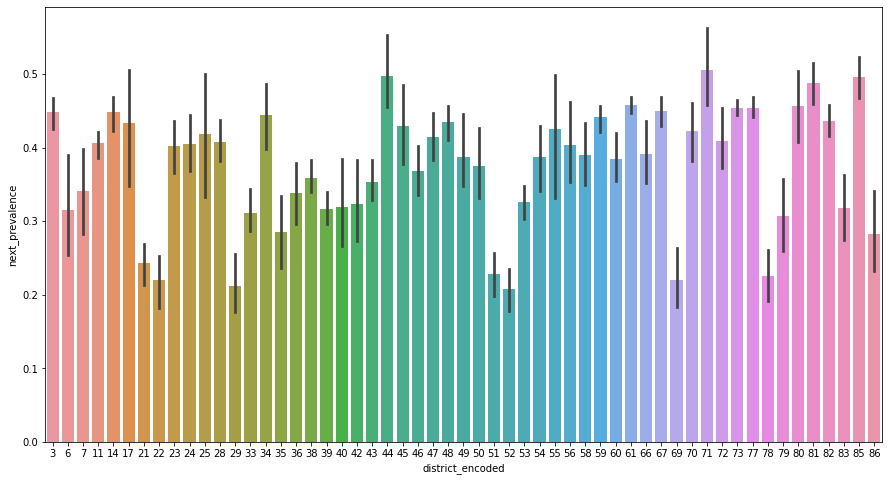

In [301]:
# the plot of baseline model best featrure against target variable
fig = plt.figure(figsize=(15,8))
ax = plt.subplot()
sns.barplot(x='district_encoded' ,y='next_prevalence',data=df,ax=ax)

In [302]:
Xtest['next_prevalence'] = df.iloc[275:]['next_prevalence']
Xtest['district'] = df.iloc[275:]['district']
Xtest['predictions'] = predictions
Xtest['date'] = df.iloc[275:]['date']

/var/folders/5_/kbn_rbxx7r58wh4vqxvfhny40000gn/T/ipykernel_18341/3911164048.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest['next_prevalence'] = df.iloc[275:]['next_prevalence']
/var/folders/5_/kbn_rbxx7r58wh4vqxvfhny40000gn/T/ipykernel_18341/3911164048.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest['district'] = df.iloc[275:]['district']
/var/folders/5_/kbn_rbxx7r58wh4vqxvfhny40000gn/T/ipykernel_18341/3911164048.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [306]:
Xtest_2020 = Xtest[Xtest['date']=='2020-07-01']
Xtest_2020

,prevalence_6lag,covid,ndvi,ipc,population,month,actor1_Al Shabaab_6m,actor2_Al Shabaab_6m,fatalities_6m,interaction_28_6m,...,interaction_27_1y6m,actor2_Al Shabaab_1y6m,actor1_Police Forces of Somalia (2017-2022)_1y6m,actor1_Military Forces of Somalia (2017-2022)_1y6m,actor2_Military Forces of Somalia (2017-2022)_1y6m,district_encoded,next_prevalence,district,predictions,date
317,0.360754,5.0,0.225000,0.09,59092.0,7,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,28,0.378173,Burtinle,0.356483,2020-07-01
318,0.495492,5.0,0.310000,0.08,231850.0,7,18.0,3.0,63.0,3.0,...,13.0,16.0,4.0,18.0,24.0,17,0.247466,Belet Weyne,0.472967,2020-07-01
319,0.420557,5.0,0.205000,0.13,52515.0,7,3.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,70,0.355069,Qandala,0.411091,2020-07-01
320,0.377253,5.0,0.161667,0.07,53457.0,7,0.0,0.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,79,0.283442,Taleex,0.313937,2020-07-01
321,0.444339,5.0,0.463333,0.02,207773.0,7,24.0,1.0,37.0,5.0,...,7.0,7.0,0.0,1.0,50.0,73,0.459391,Qoryooley,0.435015,2020-07-01
322,0.232443,5.0,0.151667,0.09,179997.0,7,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,21,0.205833,Berbera,0.232411,2020-07-01
323,0.648001,5.0,0.406667,0.05,61939.0,7,2.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,4.0,71,0.508475,Qansax Dheere,0.423778,2020-07-01
324,0.414704,5.0,0.320000,0.01,66459.0,7,7.0,2.0,49.0,0.0,...,5.0,12.0,1.0,6.0,14.0,82,0.471407,Wanla Weyn,0.447271,2020-07-01
325,0.208140,5.0,0.256667,0.12,71386.0,7,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,78,0.182837,Sheikh,0.193201,2020-07-01
326,0.213871,5.0,0.228333,0.06,453434.0,7,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,22,0.191211,Borama,0.202224,2020-07-01
